In [1]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter

# Keras imports
from keras.models import Model
from keras import backend as K

# ML4CVD Imports
from ml4cvd.arguments import parse_args
from ml4cvd.models import make_multimodal_multitask_model, train_model_from_generators
from ml4cvd.tensor_generators import TensorGenerator, big_batch_from_minibatch_generator, test_train_valid_tensor_generators

# IPython imports
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt

# IPython imports
from IPython.display import Image

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '


In [47]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~ Scale with Temperature ~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def temperature_scale(predictions, temperature=1.0):
	predictions = np.log(predictions) / temperature
	return np.exp(predictions)
#1 / (1 + np.exp(-x / temperature))

In [19]:
sys.argv = ['train', 
            '--tensors', '/mnt/disks/ecg-rest-36k-tensors/2019-10-22/', 
            '--input_tensors', 'ecg_rest', 
            '--output_tensors', 'ecg_rhythm',
            '--batch_size', '32', 
            '--epochs', '1',  
            '--learning_rate', '0.0001',
            '--model_file', '/home/sam/ml/trained_models/ecg_rest_rhythm_w_poor/ecg_rest_rhythm_w_poor.hd5',
            '--test_steps', '96',
            '--inspect_model',
            '--id', 'ecg_rhythm']
args = parse_args()
generate_train, generate_valid, generate_test = test_train_valid_tensor_generators(args.tensor_maps_in,  args.tensor_maps_out,  args.tensors, args.batch_size,   args.valid_ratio, args.test_ratio, args.test_modulo, args.balance_csvs)
model = make_multimodal_multitask_model(**args.__dict__)
test_data, test_labels, test_paths = big_batch_from_minibatch_generator(args.tensor_maps_in, args.tensor_maps_out,
                                                                        generate_test, args.test_steps)

2019-11-13 22:35:17,398 - logger:25 - INFO - Logging configuration was loaded. Log messages can be found at ./recipes_output/ecg_rhythm/log_2019-11-13_22-35_0.log.
2019-11-13 22:35:17,400 - arguments:198 - INFO - Command Line was:

./scripts/tf.sh train --tensors /mnt/disks/ecg-rest-36k-tensors/2019-10-22/ --input_tensors ecg_rest --output_tensors ecg_rhythm --batch_size 32 --epochs 1 --learning_rate 0.0001 --model_file /home/sam/ml/trained_models/ecg_rest_rhythm_w_poor/ecg_rest_rhythm_w_poor.hd5 --test_steps 96 --inspect_model --id ecg_rhythm



2019-11-13 22:35:17,402 - arguments:199 - INFO - Total TensorMaps:283 Arguments are Namespace(activation='relu', aligned_dimension=16, alpha=0.5, app_csv=None, b_slice_force=None, balance_csvs=[], batch_size=32, bigquery_credentials_file='/mnt/ml4cvd/projects/jamesp/bigquery/bigquery-viewer-credentials.json', bigquery_dataset='broad-ml4cvd.ukbb7089_r10data', block_size=3, categorical_field_ids=[], continuous_field_ids=[], conv_bn=False, conv_d

2019-11-13 22:36:24,545 - tensor_generators:269 - INFO - Input tensor 'input_strip_ecg_rest' has shape (3072, 5000, 12)
2019-11-13 22:36:24,553 - tensor_generators:272 - INFO - Output tensor 'output_ecg_rhythm_categorical' has shape (3072, 6)


In [45]:
predictions = model.predict(test_data)

In [21]:
print(predictions.shape)

(3072, 6)


In [66]:
def plot_predicted_distributions(predictions, n_bins=8, sharey=True, labels=None):
    sides = int(np.ceil(np.sqrt(predictions.shape[-1])))
    _, axes = plt.subplots(sides-1, sides, figsize=(12, 8), sharey=sharey)
    for i in range(predictions.shape[-1]):
        axes[i//sides, i%sides].hist(predictions[..., i], bins=n_bins)
        if labels is not None:
            axes[i//sides, i%sides].set_title(labels[i])

In [67]:
print(args.tensor_maps_out[0].channel_map)
print('prediction:',np.sum(predictions, axis=0))
print('truth:', np.sum(test_labels['output_ecg_rhythm_categorical'], axis=0))

{'Normal_sinus_rhythm': 0, 'Sinus_bradycardia': 1, 'Marked_sinus_bradycardia': 2, 'Other_sinus_rhythm': 3, 'Atrial_fibrillation': 4, 'Other_rhythm': 5}
prediction: [1236.966    1092.7585    275.71997   275.52686    66.382195  124.64262 ]
truth: [1449. 1107.  275.  185.   35.   21.]


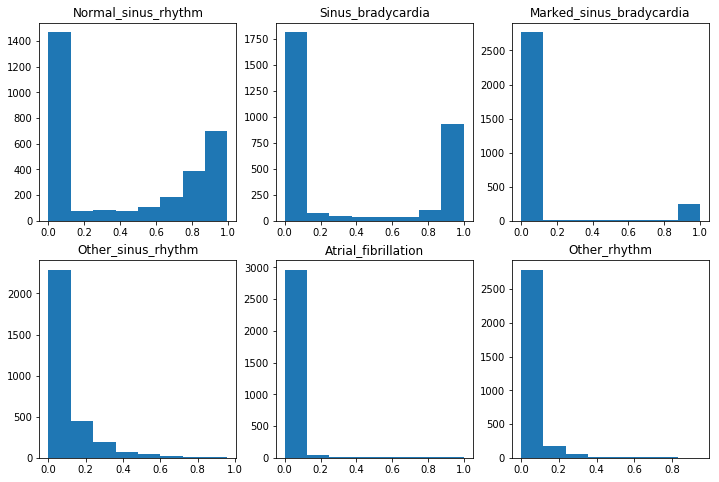

In [68]:
labels = {v: k for k, v in args.tensor_maps_out[0].channel_map.items()}
plot_predicted_distributions(predictions, labels=labels, sharey=False)

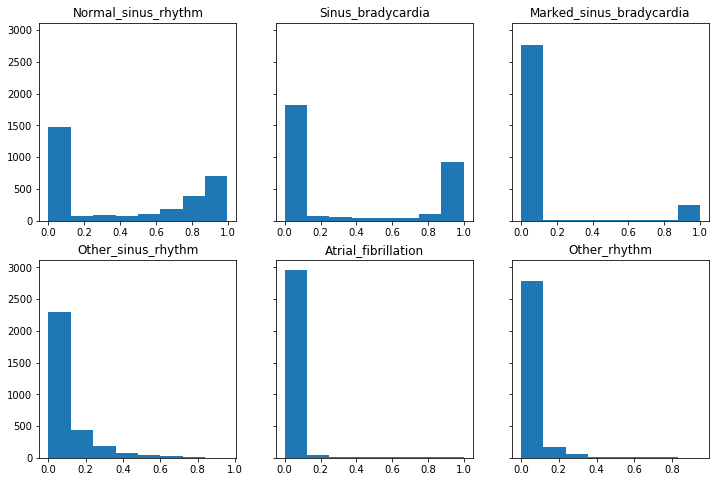

In [79]:
cold_p = temperature_scale(predictions, temperature=1.0)
plot_predicted_distributions(cold_p, labels=labels, sharey=True)

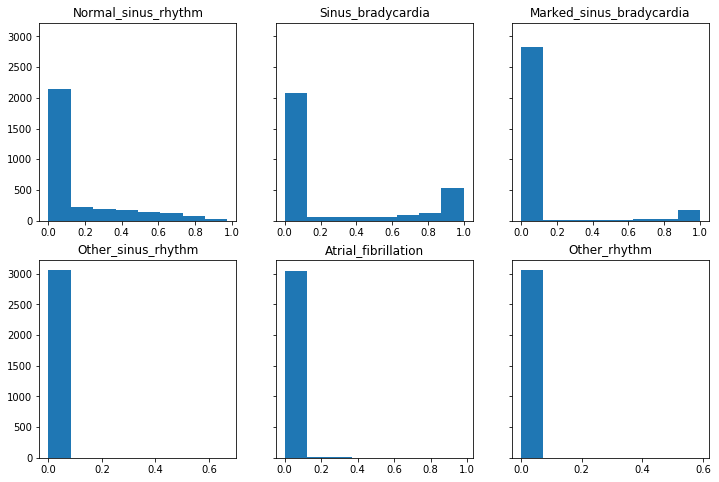

In [80]:
cold_p = temperature_scale(predictions, temperature=0.1)
plot_predicted_distributions(cold_p, labels=labels, sharey=True)


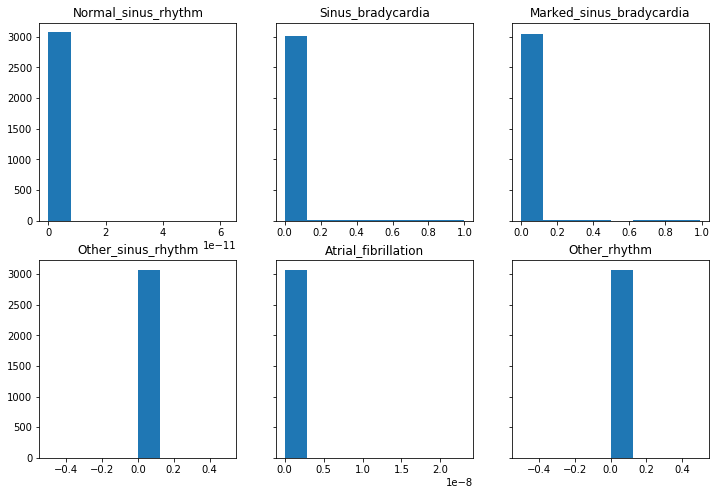

In [81]:
cold_p = temperature_scale(predictions, temperature=0.0001)
plot_predicted_distributions(cold_p, labels=labels, sharey=True)

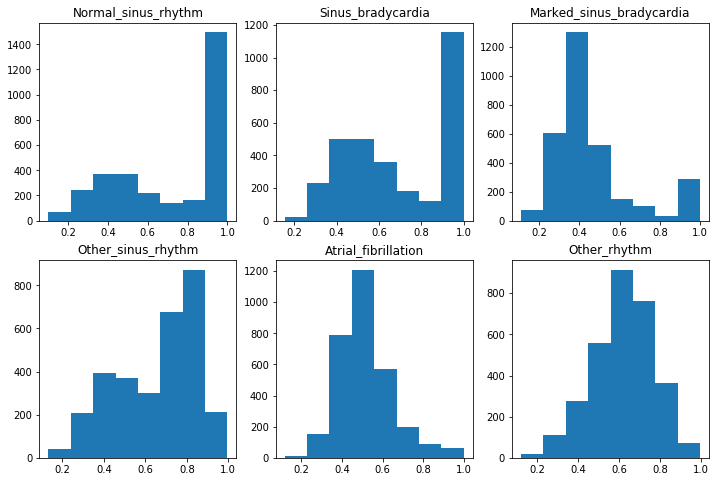

In [82]:
hot_p = temperature_scale(predictions, temperature=10.1)
plot_predicted_distributions(hot_p, labels=labels, sharey=False)

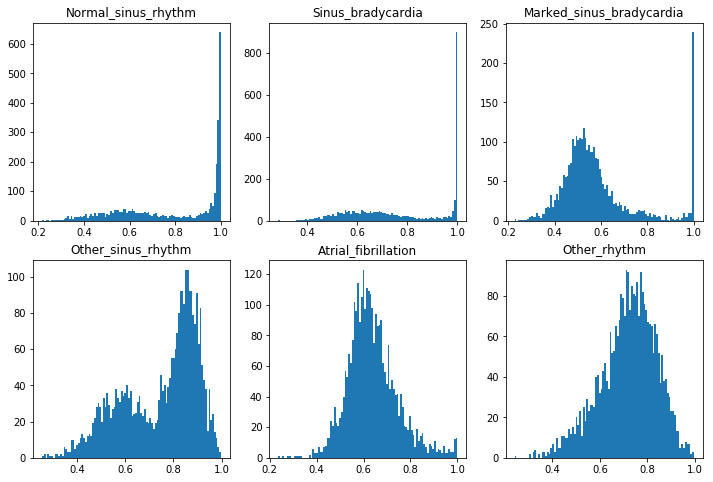

In [91]:
hot_p = temperature_scale(predictions, temperature=15)
plot_predicted_distributions(hot_p, labels=labels, sharey=False, n_bins=100)

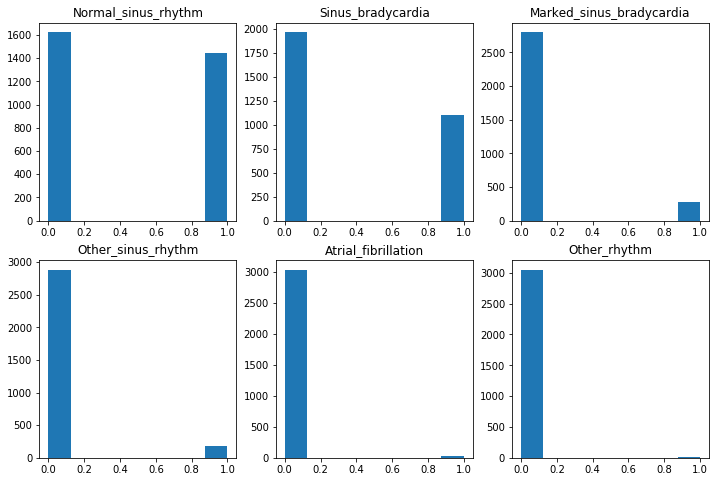

In [84]:
plot_predicted_distributions(test_labels['output_ecg_rhythm_categorical'], labels=labels, sharey=False)


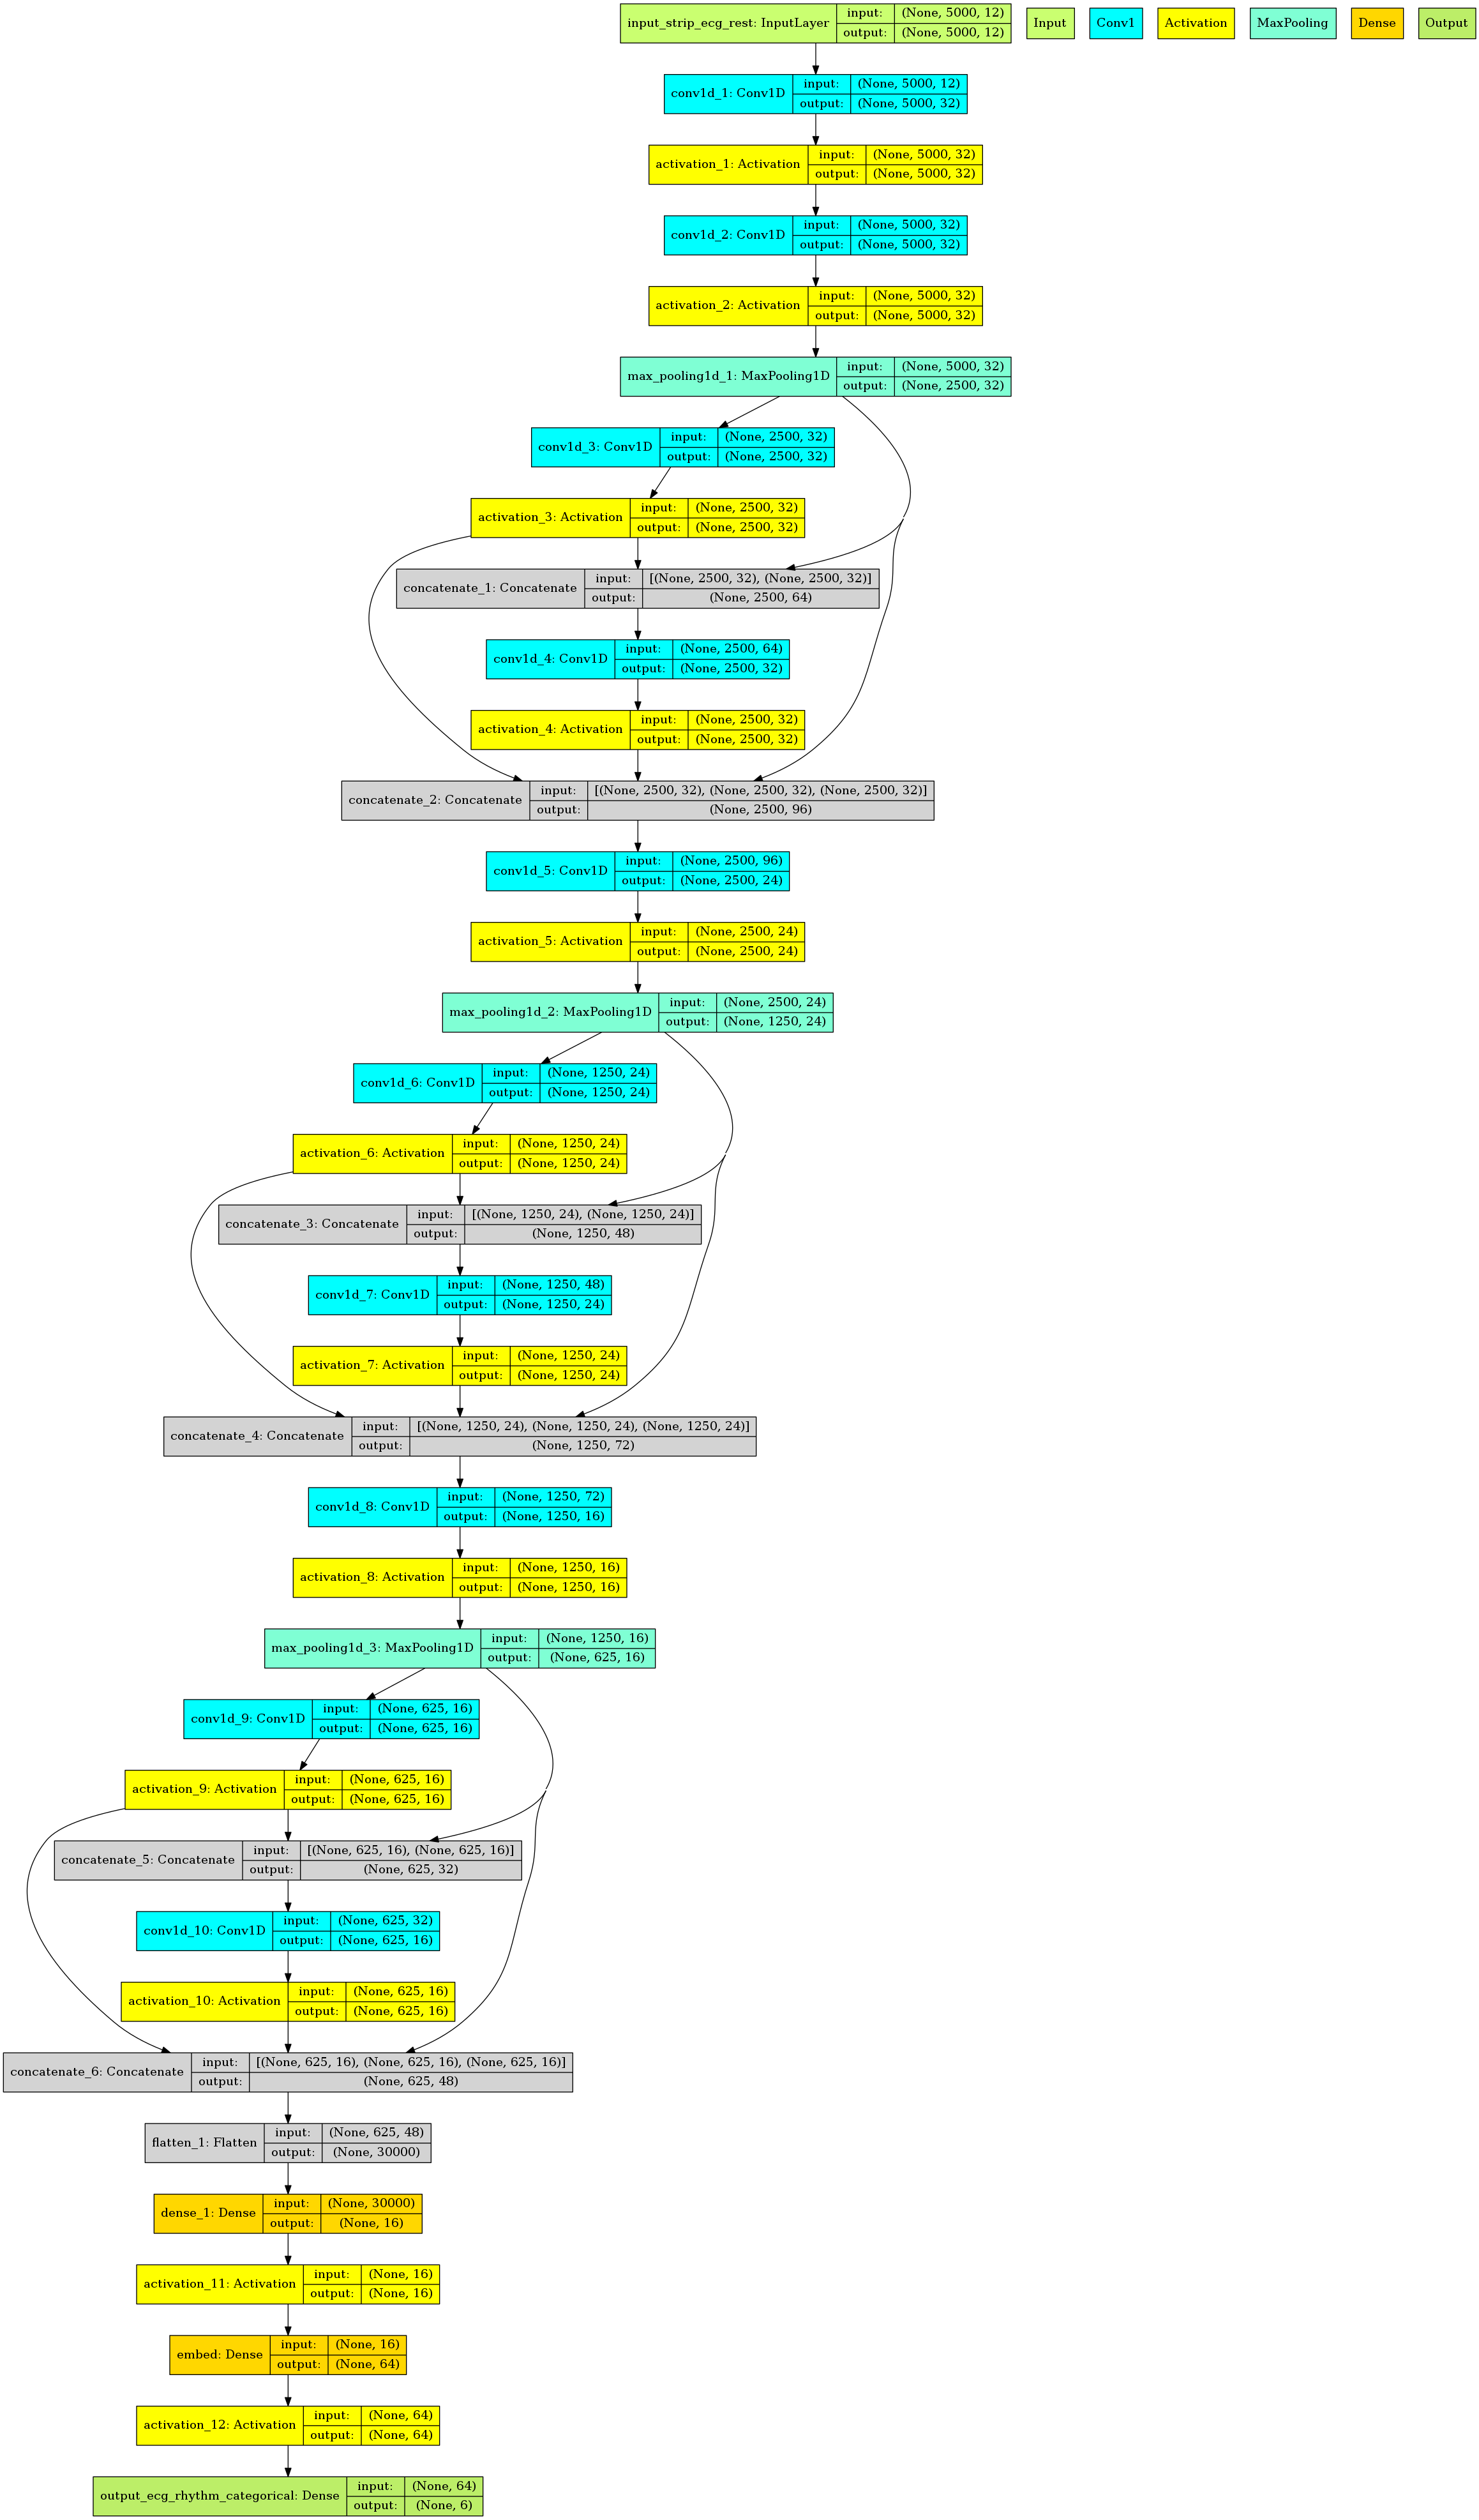

In [75]:
Image('./recipes_output/ecg_rhythm/architecture_graph_ecg_rhythm.png')

In [76]:
Image('./recipes_output/ecg_regresser/per_class_roc_ecg_rhythm.png')

TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

In [77]:
Image('./recipes_output/ecg_regresser/per_class_roc_ecg_normal.png')

TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

In [78]:
Image('./recipes_output/ecg_regresser/scatter_PPInterval.png')

TypeError: a bytes-like object is required, not 'str'

TypeError: a bytes-like object is required, not 'str'

<IPython.core.display.Image object>

In [ ]:
Image('./recipes_output/ecg_regresser/scatter_QRSDuration.png')